<a href="https://colab.research.google.com/github/NagaSaiRam89/21_daysML/blob/main/Day_3/Class_running.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import os

# Set plot style
sns.set_style('whitegrid')

In [ ]:
# Install the Kaggle library
!pip install -q kaggle

# Use Colab's file uploader
from google.colab import files
print("Please upload the kaggle.json file you downloaded from your Kaggle account.")
files.upload()

# Create a directory for the Kaggle API configuration
!mkdir -p ~/.kaggle
# Move the uploaded kaggle.json to the required directory
!cp kaggle.json ~/.kaggle/
# Set the correct permissions for the file
!chmod 600 ~/.kaggle/kaggle.json

print("\nKaggle API configured successfully.")

Please upload the kaggle.json file you downloaded from your Kaggle account.


Saving kaggle.json to kaggle (1).json

Kaggle API configured successfully.


In [ ]:
# Download the dataset from the 'house-prices-advanced-regression-techniques' competition
!kaggle competitions download -c house-prices-advanced-regression-techniques

# Unzip the downloaded files
!unzip -o house-prices-advanced-regression-techniques.zip

print("\nDataset downloaded and unzipped.")

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               

Dataset downloaded and unzipped.


In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.set_index('Id', inplace=True)
test_df.set_index('Id', inplace=True)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(1460, 80)
(1459, 79)


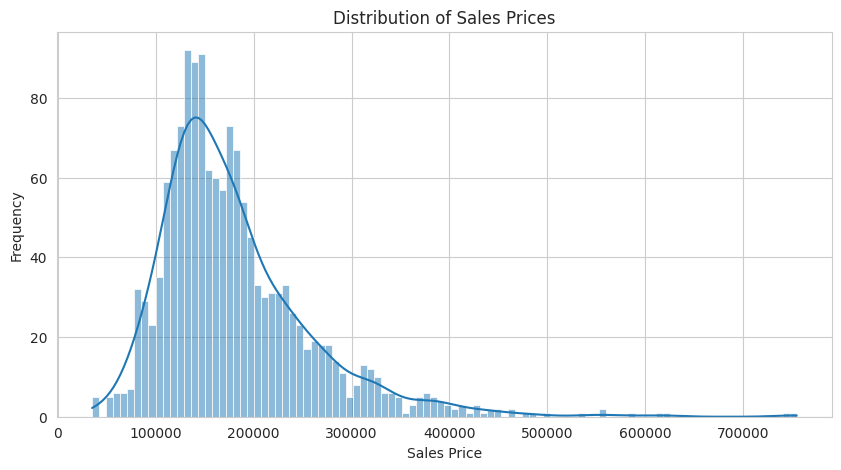

np.float64(1.8828757597682129)

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(train_df['SalePrice'], kde=True,  bins=100)
plt.xlabel('Sales Price')
plt.ylabel('Frequency')
plt.title('Distribution of Sales Prices')
plt.show()
train_df['SalePrice'].skew()

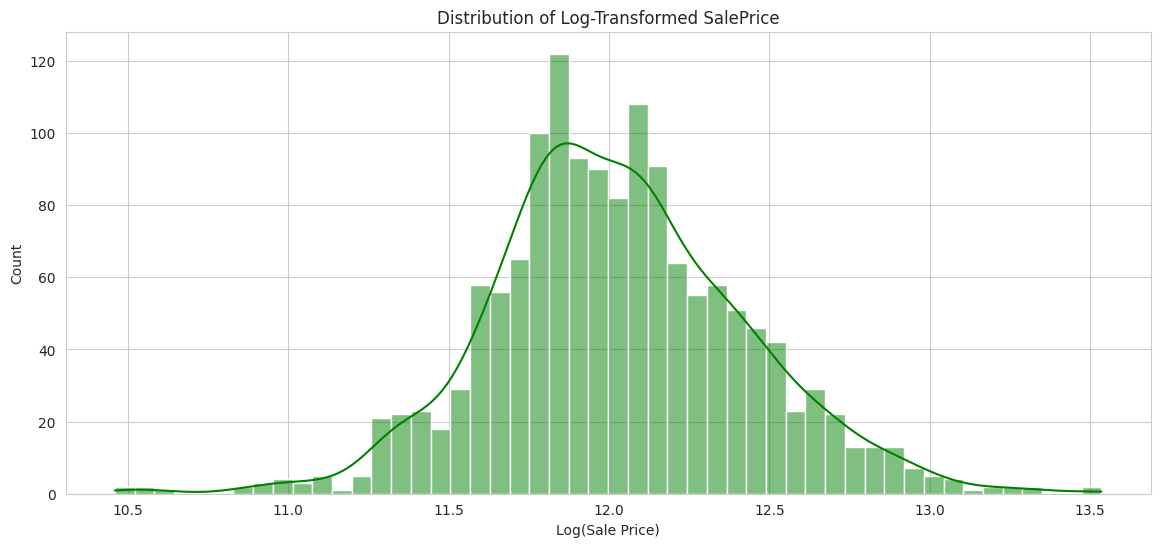

Skewness of Log-Transformed SalePrice: 0.12134661989685333


In [ ]:
train_df['SalePrice'] = train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
# //np.log1p =log(1+x) this will help even when x is zero
plt.figure(figsize=(14, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=50, color='green')
plt.title('Distribution of Log-Transformed SalePrice')
plt.xlabel('Log(Sale Price)')
plt.show()

print(f"Skewness of Log-Transformed SalePrice: {train_df['SalePrice'].skew()}")

In [ ]:
corrmat = train_df.corr(numeric_only=True)
# print(corrmat)
top_corr_features = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
# print(top_corr_features)
top_corr_matrix = train_df[top_corr_features].corr()
print(top_corr_matrix)

              SalePrice  OverallQual  GrLivArea  GarageCars  GarageArea  \
SalePrice      1.000000     0.817185   0.700927    0.680625    0.650888   
OverallQual    0.817185     1.000000   0.593007    0.600671    0.562022   
GrLivArea      0.700927     0.593007   1.000000    0.467247    0.468997   
GarageCars     0.680625     0.600671   0.467247    1.000000    0.882475   
GarageArea     0.650888     0.562022   0.468997    0.882475    1.000000   
TotalBsmtSF    0.612134     0.537808   0.454868    0.434585    0.486665   
1stFlrSF       0.596981     0.476224   0.566024    0.439317    0.489782   
FullBath       0.594771     0.550600   0.630012    0.469672    0.405656   
YearBuilt      0.586570     0.572323   0.199010    0.537850    0.478954   
YearRemodAdd   0.565608     0.550684   0.287389    0.420622    0.371600   

              TotalBsmtSF  1stFlrSF  FullBath  YearBuilt  YearRemodAdd  
SalePrice        0.612134  0.596981  0.594771   0.586570      0.565608  
OverallQual      0.537808  0

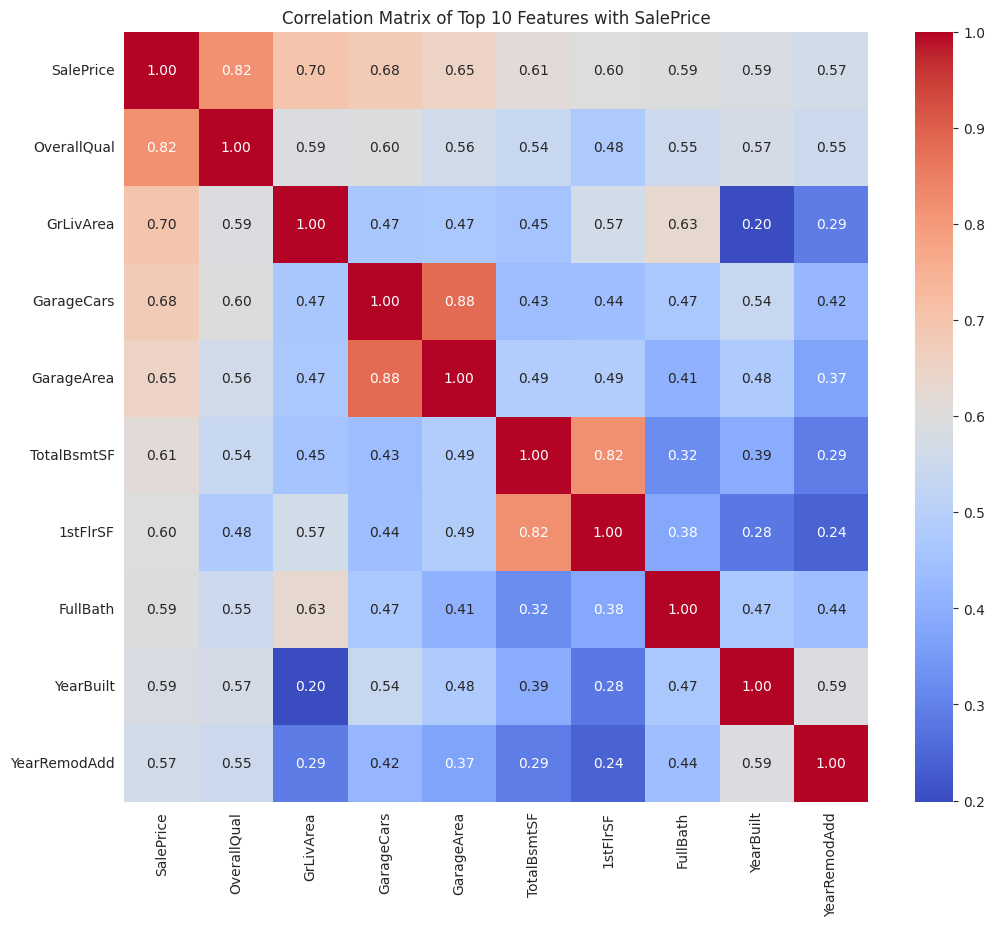

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Top 10 Features with SalePrice')
plt.show()

In [ ]:
all_data = pd.concat((train_df.loc[:,:'SaleCondition'],
                      test_df.loc[:,:'SaleCondition']))

print(f"Combined data shape: {all_data.shape}")

Combined data shape: (2919, 79)


In [ ]:
missing_data = all_data.isna().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]

print("Features with missing values:")
print(missing_data)

Features with missing values:
PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Functional         2
BsmtFullBath       2
Utilities          2
Exterior1st        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF1         1
SaleType           1
KitchenQual        1
GarageCars         1
GarageArea         1
Electrical         1
Exterior2nd        1
BsmtFinSF2         1
dtype: int64


In [ ]:
numerical_cols_to_impute_zero = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'BsmtFullBath', 'BsmtHalfBath']
for col in numerical_cols_to_impute_zero:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(0)

In [ ]:
all_data[numerical_cols_to_impute_zero].isnull().sum()

,0
MasVnrArea,0
BsmtFinSF1,0
BsmtFinSF2,0
BsmtUnfSF,0
TotalBsmtSF,0
GarageCars,0
GarageArea,0
BsmtFullBath,0
BsmtHalfBath,0


In [ ]:
all_data['LotFrontage'].value_counts()

,count
LotFrontage,
60.0,276
80.0,137
70.0,133
50.0,117
75.0,105
...,...
155.0,1
126.0,1
200.0,1


In [ ]:
if 'LotFrontage' in all_data.columns and all_data['LotFrontage'].isnull().any():
    all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [ ]:
# Impute categorical features with 'None' (for features where NA means 'no') or mode (for features where NA means missing data)
categorical_cols_to_impute_none = ['Alley', 'Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
for col in categorical_cols_to_impute_none:
    if col in all_data.columns: # Check if column exists after one-hot encoding
        all_data[col] = all_data[col].fillna('None')

for col in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Utilities', 'Functional', 'MSZoning']:
    if col in all_data.columns: # Check if column exists after one-hot encoding
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [ ]:
# Based on the likely remaining missing values (GarageYrBlt), impute the remaining numerical features.
# GarageYrBlt can be imputed with 0 (assuming 0 means no garage, consistent with GarageArea/Cars=0)
if 'GarageYrBlt' in all_data.columns:
    all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)


print("\nMissing values after all imputation:", all_data.isnull().sum().sum())


Missing values after all imputation: 0


In [ ]:
# Create a total square footage feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Create a total bathrooms feature
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                         all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

# Create a feature for age of the house at sale
all_data['Age'] = all_data['YrSold'] - all_data['YearBuilt']

print("New features created.")

New features created.


In [ ]:
all_data['Neighborhood'].value_counts()

,count
Neighborhood,
NAmes,443
CollgCr,267
OldTown,239
Edwards,194
Somerst,182
NridgHt,166
Gilbert,165
Sawyer,151
NWAmes,131


In [ ]:
# Convert any remaining object columns to category type for one-hot encoding
categorical_cols = all_data.select_dtypes(include=['object']).columns
all_data = pd.get_dummies(all_data, columns=categorical_cols, drop_first=True)

print(f"Data shape after encoding: {all_data.shape}")

Data shape after encoding: (2919, 262)


In [ ]:
# Separate the preprocessed data back into training and testing sets
X = all_data[:len(train_df)]
y = train_df['SalePrice'] # SalePrice was already log-transformed and is only in train_df
X_test_final = all_data[len(train_df):]

# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_final_scaled = scaler.transform(X_test_final)

In [ ]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror', # Corrected objective function
                        n_estimators=1000,
                        learning_rate=0.05,
                        max_depth=3,
                        min_child_weight=1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42)

# XGBoost can handle NaNs, but since we've cleaned the data, we can use the scaled data as well if preferred.
# However, XGBoost generally doesn't require scaling. We'll use the unscaled data as it's a tree-based model.
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_val)